# Lab 4 Report
## Bashar Awada
## Nadine Zaatary

## Regularization: application with medical microbiology diagnosis

We want to predict the IBD (Inflammatory Bowel Disease) clinical status of patients **given the abundance of microbial species** living in their gut.

Each patient is assigned to a clinical status, and the abundances of known species in their gut are reported in a matrix of size `patient x species`.

We focus here on the seminal metagenomic study by Nielsen H.B. et al, published in 2014.



In [3]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,KFold
from sklearn.metrics import roc_auc_score

# Viz
import matplotlib.pyplot as plt

In [4]:
# Load the data
ab_data_pd = pd.read_csv("gut_abundances.tsv", sep="\t", header = 0)
descriptor_names = ab_data_pd.columns
ab_data = ab_data_pd.to_numpy()
status_txt =  pd.read_csv("ibd_status.lst", sep="\t", header = None).to_numpy()
ab_data_pd

,k__Bacteria,k__Archaea,k__Viruses,k__Bacteria|p__Bacteroidetes,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Actinobacteria,k__Archaea|p__Euryarchaeota,k__Bacteria|p__Verrucomicrobia,k__Viruses|p__Viruses_noname,...,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Thioalkalivibrio,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Labrenzia,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname|s__Dahlia_latent_viroid,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia|s__Leifsonia_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Thioalkalivibrio|s__Thioalkalivibrio_unclassified,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Labrenzia|s__Labrenzia_unclassified,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname|s__Dahlia_latent_viroid|t__PRJNA186953
MH0001,99.85542,0.12024,0.02435,75.76233,22.45185,0.79821,0.77138,0.12024,0.04902,0.02435,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0002,99.84094,0.00000,0.15906,29.66601,63.00964,0.80546,1.31857,0.00000,5.02320,0.15906,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0003,99.99769,0.00000,0.00231,28.89089,68.87499,1.10182,1.11216,0.00000,0.00000,0.00231,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0004,99.54958,0.44427,0.00615,36.82369,59.90264,0.96707,1.79713,0.44427,0.00000,0.00615,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0005,99.85338,0.02338,0.12324,53.45066,44.00230,0.66402,1.34265,0.02338,0.33886,0.12324,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V1_UC61_0,100.00000,0.00000,0.00000,73.60036,23.13241,1.97125,1.29598,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC62_0,99.43677,0.53534,0.02789,59.81443,31.16507,1.25950,7.12218,0.53534,0.07560,0.02789,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC7_0,99.97056,0.00000,0.02944,61.47615,31.97288,3.65580,1.59657,0.00000,1.25953,0.02944,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC8_0,96.71485,3.21396,0.01313,26.64142,56.61496,0.68027,7.95935,3.21396,4.79898,0.01313,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


Take a look at the data: number of samples ($n$), number of descriptors ($p$), names of descriptors (in ```descriptor_names```), etc.

In [5]:
n,p = ab_data_pd.shape #TO COMPLETE (1 expression)
print("Data shape:",n,p)

Data shape: 396 1939


We now transform the target variable to a binary (0 ==  control, 1 == IBD) variable ```status```:

In [6]:
status = np.ravel([int(s == "IBD") for s in status_txt])

What is the name of the most correlated species (we denote by S) to the clinical status? Use the ```np.corrcoef``` function to compute the correlation between the data and the status.
You can compute the correlation between the data and the status using ```corr_vector = np.corrcoef(ab_data.transpose(),status)[:-1,p]```, which gives the correlation for each species.

In [7]:
# creating a correlation between the bacteria and the status
#finding the most correlated species
corr_vector = np.corrcoef(ab_data.transpose(),status)[:-1,p] #TO COMPLETE
print("max correlation is ",max(corr_vector))
maxarg = corr_vector.argmax()
print("index in array is :",maxarg)
most_species = descriptor_names[maxarg]
print("most correlated species to the clinical status is " ,most_species)


max correlation is  0.40722498985588496
index in array is : 6
most correlated species to the clinical status is  k__Bacteria|p__Actinobacteria


### Answer 1: 
<span style="color:blue">After calculating the correlation between the data and the status, we obtained that the most correlated species is k__Bacteria|p__Actinobacteria </span>

Create a (naïve) predictor that takes as input the abundance of S and output the clinical status of the patient. Either compute the prediction accuracy or its AUC ROC for every threshold, this will be our baseline predictor to improve on.

(198, 1939)
(396, 1939)
6


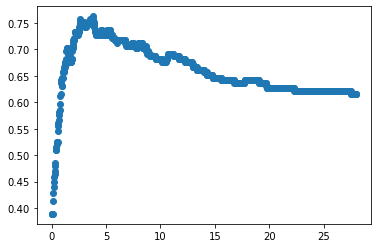

AUC ROC on test set: 0.6934523809523809


In [6]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)
print(x_train.shape)
print(ab_data.shape)

# We remove species not abundant in the train set
col_to_rm = np.where(np.sum(x_train,axis=0) == 0)
x_train = np.delete(x_train,col_to_rm,axis=1)
x_test =  np.delete(x_test,col_to_rm,axis=1)
n,p = x_train.shape

# Index of the best correlated species to patient's status
corr_vector = np.corrcoef(x_train.transpose(),y_train)[:-1,p]
best_cor_sp = corr_vector.argmax() #TO COMPLETE (1 expression)
print(best_cor_sp)
#print(x_train[:,best_cor_sp])
# Compute accuracy 
accuracy = list()
ths = np.linspace(0,int(np.max(x_train[:,best_cor_sp]))+1,1000) # threshold list
for t in ths:
    predictions = (x_train[:,best_cor_sp]>t)
    accuracy += [sum( predictions == y_train)/n]#TO COMPLETE (1 expression)

    
# Plot the decision threshold vs. performance of the predictor

plt.scatter(ths,accuracy)
plt.show()



# "Real" accuracy on test set
# Decision threshold corresponding to the best accuracy.
best_ths =ths[np.argmax(accuracy)]#TO COMPLETE (1 expression)
# Report the accuracy on the test set
predict = (x_test[:,best_cor_sp]>best_ths)
#acc = sum( predict == y_test)/n #TO COMPLETE (1 expression)
#print(acc)
#TO COMPLETE
#TO COMPLETE

#best_ths
roc = roc_auc_score(y_test==1,predict)#TO COMPLETE (1 expression)
print("AUC ROC on test set:",roc)


### Explanation of the above steps
<span style="color:blue">At first, we split the data in half to both test and training data. Next, we removed the species that are not abundant in the training set. then, we calculated the correlation between the data and the status in our training set obtaining the index of the best correlated species to patient's status.</span>

<span style="color:blue">We plotted a decision threshold vs. performance of the predictor curve. This curve allows us to extract the best threshold from the above list.</span>

<span style="color:blue">After extracting the best threshold, we calculated then accuracy of our training model using roc_auc_score.</span>



Now we hope that we can do better when using more than 1 descriptor.

We will first use a standard [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html ) function of Sklearn to evaluate your predictor in a cross-validation way.

Take a look at what metrics you can find in the attributes of the cross-validation object `cv` and print the average accuracy.

Do you gain in terms of accuracy compared to a single predictor? Check if you are overfitting the data.

In [9]:
logreg = linear_model.LogisticRegression(solver="liblinear")
cv =cross_validate(logreg,ab_data,y=status,cv=5) #TO COMPLETE (1 expression)
print(cv["test_score"])

test_score =np.mean(cv["test_score"])#TO COMPLETE (1 expression)
print("Average Cross-Validation accuracy on test:",test_score)


# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)


# Print example accuracy on 1 fold
logreg.fit(x_train,y_train)
logreg_pred= logreg.predict(x_test)
roc = roc_auc_score(y_test,logreg_pred)
print("AUC ROC on test set:",roc)
 

[0.7375     0.84810127 0.79746835 0.78481013 0.59493671]
Average Cross-Validation accuracy on test: 0.7525632911392404
AUC ROC on test set: 0.7857142857142857


### Answer 2
<span style="color:blue"> Comparing our model with the previous naïve predictor model, we notice that our model has better accuracy than the naive one and that no overfitting is present in the second model </span>

Check the `coef_` attribute of your model. How many species are you using for taking the decision?

In [21]:
used_descriptors = logreg.coef_#TO COMPLETE (1 expression)
print("logreg coef:  ",used_descriptors)
print("The model uses ",np.count_nonzero(used_descriptors[0]),"descriptors")


logreg coef:   [[0.0326845 0.        0.        ... 0.        0.        0.       ]]
The model uses  92 descriptors


### Answer 3
<span style="color:blue"> Using logreg.coef_ we obtained an array of descriptors used. Then we counted the elements in our array to obtain the number of descriptors used which in this case is 1658 descriptors. </span>


Considering that only few bacterial species may be responsible for IBD, choose a relevant regularization (see the available penalties for logistic regression [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).



In [22]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)

# Create a regularized model
logreg_regul =linear_model.LogisticRegression(penalty = "l1",solver="liblinear")#TO COMPLETE (1 expression)
logreg_regul.fit(x_train,y_train)
pred = logreg_regul.predict(x_test)

# Report accuracy on test set
#TO COMPLETE
roc = roc_auc_score(y_test,pred)#TO COMPLETE (1 expression)
print("AUC ROC on test set:",roc)
 

AUC ROC on test set: 0.7341269841269842


Have you increased the accuracy? Looking at `logreg_regul.coef_`, how many descriptors are you using after regularization?
All things considered, is it a better model?

### Answer 4

<span style="color:blue"> we decided to choose an l1 penalty instead of l2 for the same solver. The major difference between these l1 and l2 techniques is that l1 shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features. </span>
<span style="color:blue"> Yes, it is a better model because first we have a better accuracy score and if we try to run it multiple times we may obtain the same accuracy but with a less number of descriptors in the regularized model. </span>

In [23]:
used_descriptors =logreg_regul.coef_#TO COMPLETE (1 expression)
print("logreg_regul coef: ",used_descriptors)
print("The model uses ",np.count_nonzero(used_descriptors[0]),"descriptors")


logreg_regul coef:  [[0.04534585 0.         0.         ... 0.         0.         0.        ]]
The model uses  96 descriptors


Remember that equivalent accuracy, but with fewer descriptors => more robust and explainable => better model !

Find the optimal regularization strength, by comparing performances on test set and train set. If you have more time, best is to do it by plotting the mean performance in cross-validation, with confidence enveloppe (+/- std deviation) over the folds.


[0.6364102564102564, 0.6364102564102564, 0.6512820512820513, 0.7730769230769231, 0.7780769230769231, 0.7882051282051281, 0.788076923076923, 0.7829487179487179, 0.7778205128205128, 0.7578205128205129]


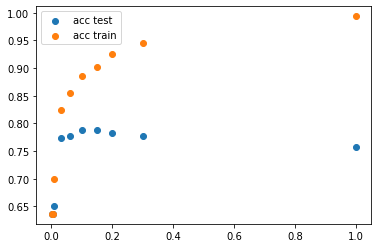

In [25]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)

acc_test = list()
acc_train = list()


reg_strengths = [0.001,0.005,0.01,0.03,0.06,0.1,0.15,0.2,0.3,1]
for c in reg_strengths:
    logreg = linear_model.LogisticRegression(penalty = "l1",solver="liblinear",C=c).fit(x_train,y_train)#TO COMPLETE (1 expression)
    cv =cross_validate(logreg,x_test,y=y_test,cv=5,return_train_score = True) #TO COMPLETE (1 expression)
    acc_test += [np.mean(cv["test_score"])]#TO COMPLETE (1 expression)
    acc_train +=[np.mean(cv["train_score"])]#TO COMPLETE (1 expression)
    
print(acc_test)
# print(len(acc_train))
plt.clf()
plt.scatter(reg_strengths,acc_test, label='acc test')
plt.scatter(reg_strengths,acc_train, label='acc train')
plt.legend()
plt.show()

### Explanation
<span style="color:blue"> In order to find the optimal regularization strength, for each value in the regularization list, we defined a new logistic regression linear model using l1 penalty with liblinear solver and then we trained it with the training data. Then, we cross validated our testing data, and calculated the accuracy test score and then append it to the accuracy test list and calculated the train score and appended the values to the accuracy train list.</span>
<span style="color:blue"> By plotting the graph of the accuracy test and accuracy train, we extracted the highest value in the accuracy test and its index in the list corresponds to the index of the optimal regularization strength value. </span>

Train a classifier on the full dataset with the optimial regularization strength, and interpret the coefficients. You can check in particular if it is consistent with [this paper](https://pubmed.ncbi.nlm.nih.gov/27999802/) and [this one](https://pubmed.ncbi.nlm.nih.gov/20648002/).

In [17]:
# c is the optimal penalty given the previous graph (hard-code this number)
c =  0.1#TO COMPLETE (1 expression)
# print(c)
logreg = linear_model.LogisticRegression(penalty = "l1",solver="liblinear",C=c)#TO COMPLETE (1 expression)
logreg.fit(ab_data,status)
# print(np.argsort(logreg.coef_))
# positive association IBD, you can make use of numpy argsort function
order =np.argsort(logreg.coef_)#TO COMPLETE (1 expression)
order = order.tolist()
# print(np.sort(logreg.coef_))
# print(order)
print("Positive association with IBD\n",np.array(descriptor_names)[order[0][0:3]])
print("\n")

# negative association with IBD
order =np.flip(np.argsort(logreg.coef_)).tolist()#TO COMPLETE (1 expression)
# print(order)
print("Negative association with IBD\n",np.array(descriptor_names)[order[0][0:3]])



Positive association with IBD
 ['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_torques'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia']


Negative association with IBD
 ['k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_unclassified'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_comes|t__GCF_000155875'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_1_1_57FAA|t__GCF_000218445']


### Explanation 

<span style="color:blue"> After choosing the optimal regularization strength value, we defined a logistic regression model using l1 penalty and liblinear solver and the c value chosen (value of the optimal regularization strength). Then, we trained this model on the full dataset. We then ordered our coefficient attribute using the np.argsort(logreg.coef_) and then extracted the first and last 3 descriptor names.</span>

<span style="color:blue"> According to the work done we were able to extract the major 3 descriptors that determine that we have positive IBD and the major 3 descriptors that determine that we have negative IBD. </span>

## Optional: other classifiers

Use other models for supervised classification (decision trees, SVM, neural nets, etc.) with the IBD data. Evaluate properly the performances, and pay attention to regularization!

